#### Regression Analysis on Interest Rate Levels

This notebook performs a regression analysis to model how central bank communication impacts the term structure of futures interest rates.
 * It uses a linear regression model to examine the relationship between changes in a positive/uncertainty factor for the diferent topics and changes in interest rates across different maturities.

In [18]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [19]:
INITIAL_DATE = "2003-06-26"

In [20]:
minutes_info = pd.read_excel("./data/raw/minutes_info.xlsx")
minutes_info = minutes_info[minutes_info["DataReferencia"] >= INITIAL_DATE]
minutes_info = minutes_info.sort_values("DataReferencia", ascending=True)

dates_ref = minutes_info["DataReferencia"]
detes_pub = minutes_info["DataPublicacao"]

In [21]:
futures_ir = pd.read_excel("./data/future_interest_rates/future_interest_rates.xlsx", index_col="Date")
futures_ir.index = pd.to_datetime(futures_ir.index)
futures_ir.sort_index(inplace=True)

#futures_ir_returns = futures_ir.pct_change().dropna()
futures_ir_returns = futures_ir.diff().dropna()

In [22]:
returns_pub_date = futures_ir_returns[futures_ir_returns.index.isin(detes_pub)]

#### Regression on optimism index

In [ ]:
df_optimism = pd.read_excel("./data/processed/index_optimism.xlsx", index_col=0)
df_optimism = df_optimism.drop(columns=["minute"])
df_optimism.columns = [f"optimism_{i}" for i in range(len(df_optimism.columns))]

df_optimism = df_optimism.diff()

In [24]:
df_optimism.std()

optimism_0    0.004322
optimism_1    0.004677
optimism_2    0.002635
optimism_3    0.008703
optimism_4    0.005676
optimism_5    0.004490
dtype: float64

In [25]:
regression_data = pd.concat([returns_pub_date, df_optimism], axis=1)
regression_data.dropna(inplace=True)

possible_y = returns_pub_date.columns.tolist()
all_x = df_optimism.columns.tolist()

In [ ]:
reg_level_optimism = []
X = regression_data[all_x]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for maturity in possible_y:
    Y = regression_data[maturity]

    lasso_cv_model = LassoCV(cv=10, random_state=100, max_iter=10000)
    lasso_cv_model.fit(X_scaled, Y)

    selected_coeffs_mask = lasso_cv_model.coef_ != 0
    selected_variables_names = X.columns[selected_coeffs_mask].tolist()


    X_selected = X[selected_variables_names]
    X_selected_sm = sm.add_constant(X_selected)

    ols_final_model = sm.OLS(Y, X_selected_sm).fit()

    all_var_names_with_const = ["const"] + selected_variables_names # Cria a lista de nomes correta
    ols_params = pd.Series(ols_final_model.params.values, index=all_var_names_with_const)
    ols_std = pd.Series(ols_final_model.bse.values, index=all_var_names_with_const)
    ols_pvalues = pd.Series(ols_final_model.pvalues.values, index=all_var_names_with_const)

    reg_level_optimism.append({
        "Vertix": maturity,
        "Selected_Alpha": lasso_cv_model.alpha_,
        "Coefs_OLS_Final": ols_params,
        "Std_OLS_Final": ols_std,
        "Pvalues_OLS_Final": ols_pvalues,
        "Adj_R_Sqrd_OLS_Final": ols_final_model.rsquared_adj
    })


In [ ]:
for result in reg_level_optimism:
    print(f"#### Results for Maturity (Vertex): {result["Vertix"]}")
    print(f"Best alpha (λ) found by cross-validation: {result["Selected_Alpha"]:.6f}")
    print(f"Adjusted R squared of the final OLS model: {result["Adj_R_Sqrd_OLS_Final"]:.4f}")
            
    # --- Final OLS Model Results ---
    if not result["Coefs_OLS_Final"].empty:
        print("\n  Final OLS Results:")
        for var in result["Coefs_OLS_Final"].index:
            coef = result["Coefs_OLS_Final"][var]
            std_err = result["Std_OLS_Final"][var]
            pval = result["Pvalues_OLS_Final"][var]
            print(f"    - {var}: Coef = {coef:.6f}, Std. Err = {std_err:.6f}, P-value = {pval:.4f}")
    else:
        print("No variables selected.")
    print("-" * 60)

#### Results for Maturity (Vertex): v_21
Best alpha (λ) found by cross-validation: 0.001754
Adjusted R squared of the final OLS model: 0.0070

  Final OLS Results:
    - const: Coef = 0.001317, Std. Err = 0.001157, P-value = 0.2567
    - optimism_4: Coef = 0.309853, Std. Err = 0.204451, P-value = 0.1314
------------------------------------------------------------
#### Results for Maturity (Vertex): v_63
Best alpha (λ) found by cross-validation: 0.007665
Adjusted R squared of the final OLS model: 0.0256

  Final OLS Results:
    - const: Coef = -0.000370, Std. Err = 0.003175, P-value = 0.9073
    - optimism_0: Coef = 1.778237, Std. Err = 0.736467, P-value = 0.0167
------------------------------------------------------------
#### Results for Maturity (Vertex): v_126
Best alpha (λ) found by cross-validation: 0.011966
Adjusted R squared of the final OLS model: 0.0185

  Final OLS Results:
    - const: Coef = 0.006310, Std. Err = 0.005655, P-value = 0.2660
    - optimism_1: Coef = -2.565574

c:\Users\MatheusBreitenbach\Documents\VSCode_Projects\0 - TCC\br-central-bank-sentiment\.venv\Lib\site-packages\statsmodels\tsa\tsatools.py:162: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  x = pd.concat(x[::order], axis=1)
c:\Users\MatheusBreitenbach\Documents\VSCode_Projects\0 - TCC\br-central-bank-sentiment\.venv\Lib\site-packages\statsmodels\tsa\tsatools.py:162: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  x = pd.concat(x[::order], axis=1)


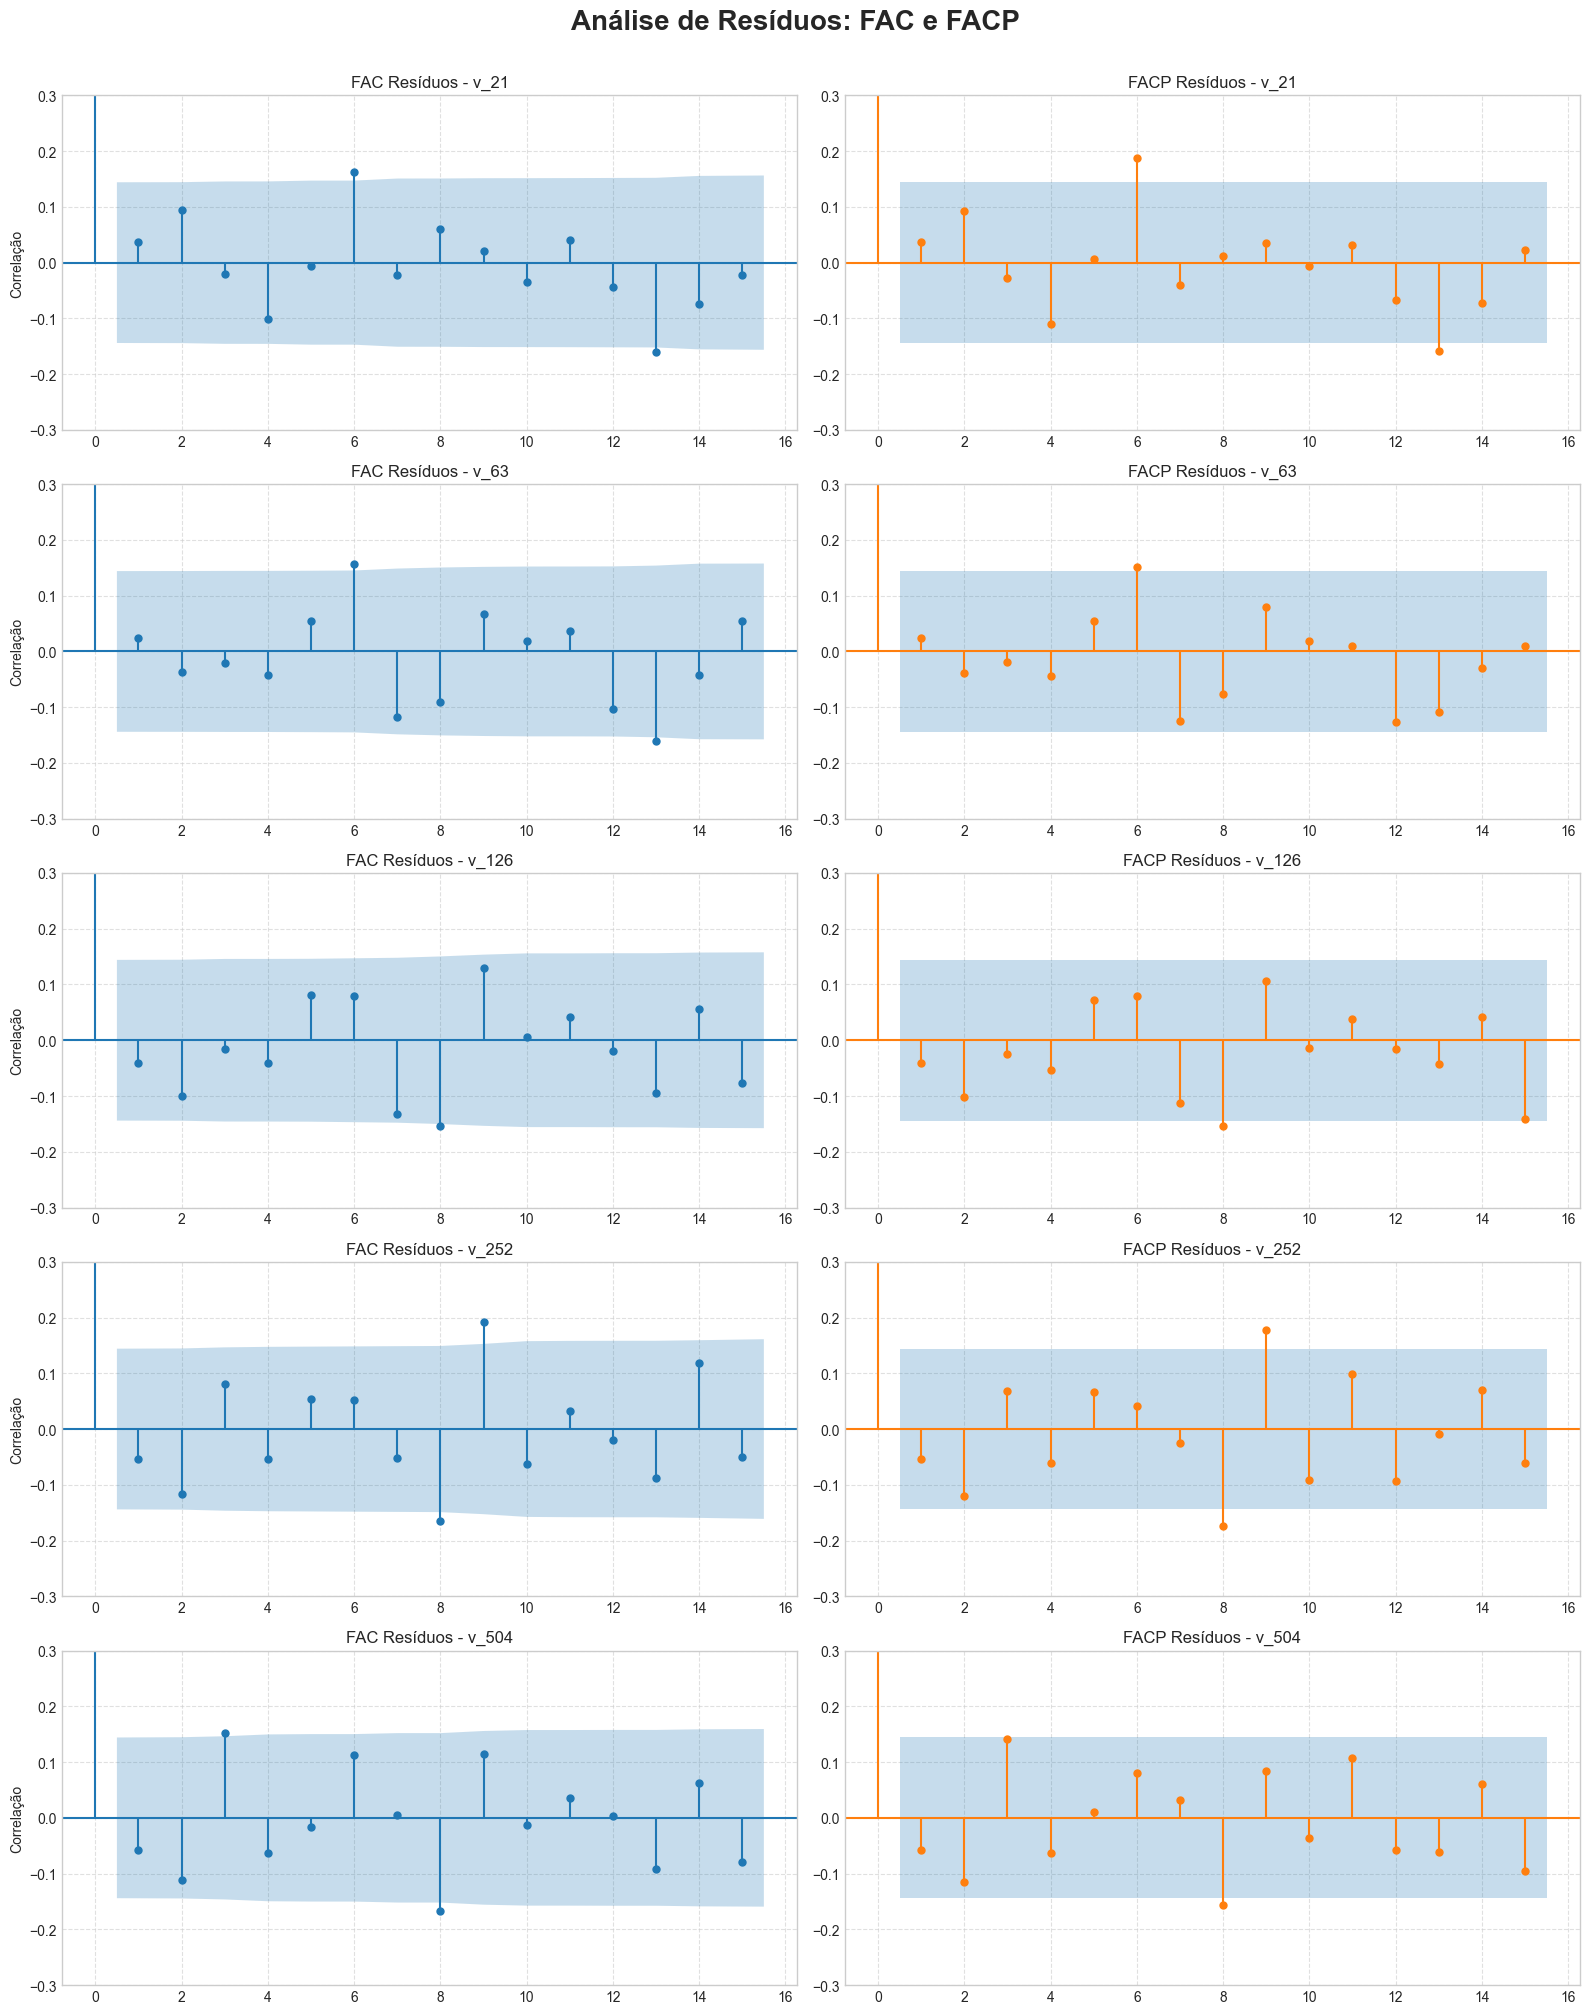

In [ ]:

plt.style.use("seaborn-v0_8-whitegrid")

results_to_analyze = reg_level_optimism 
data_source = regression_data

num_series = len(results_to_analyze)
fig, axes = plt.subplots(nrows=num_series, ncols=2, figsize=(16, 4 * num_series))

fig.suptitle("Análise de Resíduos: FAC e FACP", fontsize=20, weight="bold", y=1.005)

for i, result in enumerate(results_to_analyze):
    vertex = result["Vertix"]
    
    selected_vars = [var for var in result["Coefs_OLS_Final"].index if var != "const"]
    
    Y = data_source[vertex]
    
    if selected_vars:
        X = data_source[selected_vars]
        X = sm.add_constant(X)
    else:
        X = sm.add_constant(pd.DataFrame(index=data_source.index, data=[1]*len(data_source)))

    model_resid = sm.OLS(Y, X).fit()
    residuals = model_resid.resid.dropna()

    # FAC
    plot_acf(residuals, ax=axes[i, 0], title=f"FAC Resíduos - {vertex}", lags=15, 
             color="tab:blue", vlines_kwargs={"colors": "tab:blue"})
    axes[i, 0].set_ylabel("Correlação")
    axes[i, 0].grid(True, linestyle="--", alpha=0.6)
    axes[i, 0].set_ylim(-0.3, 0.3)

    # FACP
    plot_pacf(residuals, ax=axes[i, 1], title=f"FACP Resíduos - {vertex}", lags=15, 
              color="tab:orange", vlines_kwargs={"colors": "tab:orange"}, method="ywm")
    axes[i, 1].grid(True, linestyle="--", alpha=0.6)
    axes[i, 1].set_ylim(-0.3, 0.3) 

plt.tight_layout()
plt.show()

#### Regression on uncertainty index

In [ ]:
df_uncertainty = pd.read_excel("./data/processed/index_uncertainty.xlsx", index_col=0)
df_uncertainty = df_uncertainty.drop(columns=["minute"])
df_uncertainty.columns = [f"uncertainty_{i}" for i in range(len(df_uncertainty.columns))]

df_uncertainty = df_uncertainty.diff()

In [30]:
df_uncertainty.std()

uncertainty_0    0.005180
uncertainty_1    0.004335
uncertainty_2    0.003605
uncertainty_3    0.005469
uncertainty_4    0.005305
uncertainty_5    0.003578
dtype: float64

In [31]:
regression_data = pd.concat([returns_pub_date, df_uncertainty], axis=1)
regression_data.dropna(inplace=True)

possible_y = returns_pub_date.columns.tolist()
all_x = df_uncertainty.columns.tolist()

In [ ]:
reg_level_uncertainty = []
X = regression_data[all_x]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for maturity in possible_y:
    Y = regression_data[maturity]

    lasso_cv_model = LassoCV(cv=10, random_state=100, max_iter=10000)
    lasso_cv_model.fit(X_scaled, Y)

    selected_coeffs_mask = lasso_cv_model.coef_ != 0
    selected_variables_names = X.columns[selected_coeffs_mask].tolist()


    X_selected = X[selected_variables_names]
    X_selected_sm = sm.add_constant(X_selected)

    ols_final_model = sm.OLS(Y, X_selected_sm).fit()
    
    all_var_names_with_const = ["const"] + selected_variables_names # Cria a lista de nomes correta
    ols_params = pd.Series(ols_final_model.params.values, index=all_var_names_with_const)
    ols_std = pd.Series(ols_final_model.bse.values, index=all_var_names_with_const)
    ols_pvalues = pd.Series(ols_final_model.pvalues.values, index=all_var_names_with_const)

    reg_level_uncertainty.append({
        "Vertix": maturity,
        "Selected_Alpha": lasso_cv_model.alpha_,
        "Coefs_OLS_Final": ols_params,
        "Std_OLS_Final": ols_std,
        "Pvalues_OLS_Final": ols_pvalues,
        "Adj_R_Sqrd_OLS_Final": ols_final_model.rsquared_adj
    })

In [ ]:
for result in reg_level_uncertainty:
    print(f"#### Results for Maturity (Vertex): {result["Vertix"]}")
    print(f"Best alpha (λ) found by cross-validation: {result["Selected_Alpha"]:.6f}")
    print(f"Adjusted R squared of the final OLS model: {result["Adj_R_Sqrd_OLS_Final"]:.4f}")
            
    # --- Final OLS Model Results ---
    if not result["Coefs_OLS_Final"].empty:
        print("\n  Final OLS Results:")
        for var in result["Coefs_OLS_Final"].index:
            coef = result["Coefs_OLS_Final"][var]
            std_err = result["Std_OLS_Final"][var]
            pval = result["Pvalues_OLS_Final"][var]
            print(f"    - {var}: Coef = {coef:.6f}, Std. Err = {std_err:.6f}, P-value = {pval:.4f}")
    else:
        print("No variables selected")
    print("-" * 60)

#### Results for Maturity (Vertex): v_21
Best alpha (λ) found by cross-validation: 0.001903
Adjusted R squared of the final OLS model: 0.0092

  Final OLS Results:
    - const: Coef = 0.001350, Std. Err = 0.001156, P-value = 0.2444
    - uncertainty_3: Coef = -0.348903, Std. Err = 0.211967, P-value = 0.1015
------------------------------------------------------------
#### Results for Maturity (Vertex): v_63
Best alpha (λ) found by cross-validation: 0.004092
Adjusted R squared of the final OLS model: 0.0150

  Final OLS Results:
    - const: Coef = -0.000275, Std. Err = 0.003192, P-value = 0.9315
    - uncertainty_2: Coef = -1.729933, Std. Err = 0.887756, P-value = 0.0529
------------------------------------------------------------
#### Results for Maturity (Vertex): v_126
Best alpha (λ) found by cross-validation: 0.002895
Adjusted R squared of the final OLS model: 0.0484

  Final OLS Results:
    - const: Coef = 0.006279, Std. Err = 0.005570, P-value = 0.2611
    - uncertainty_0: Coef 

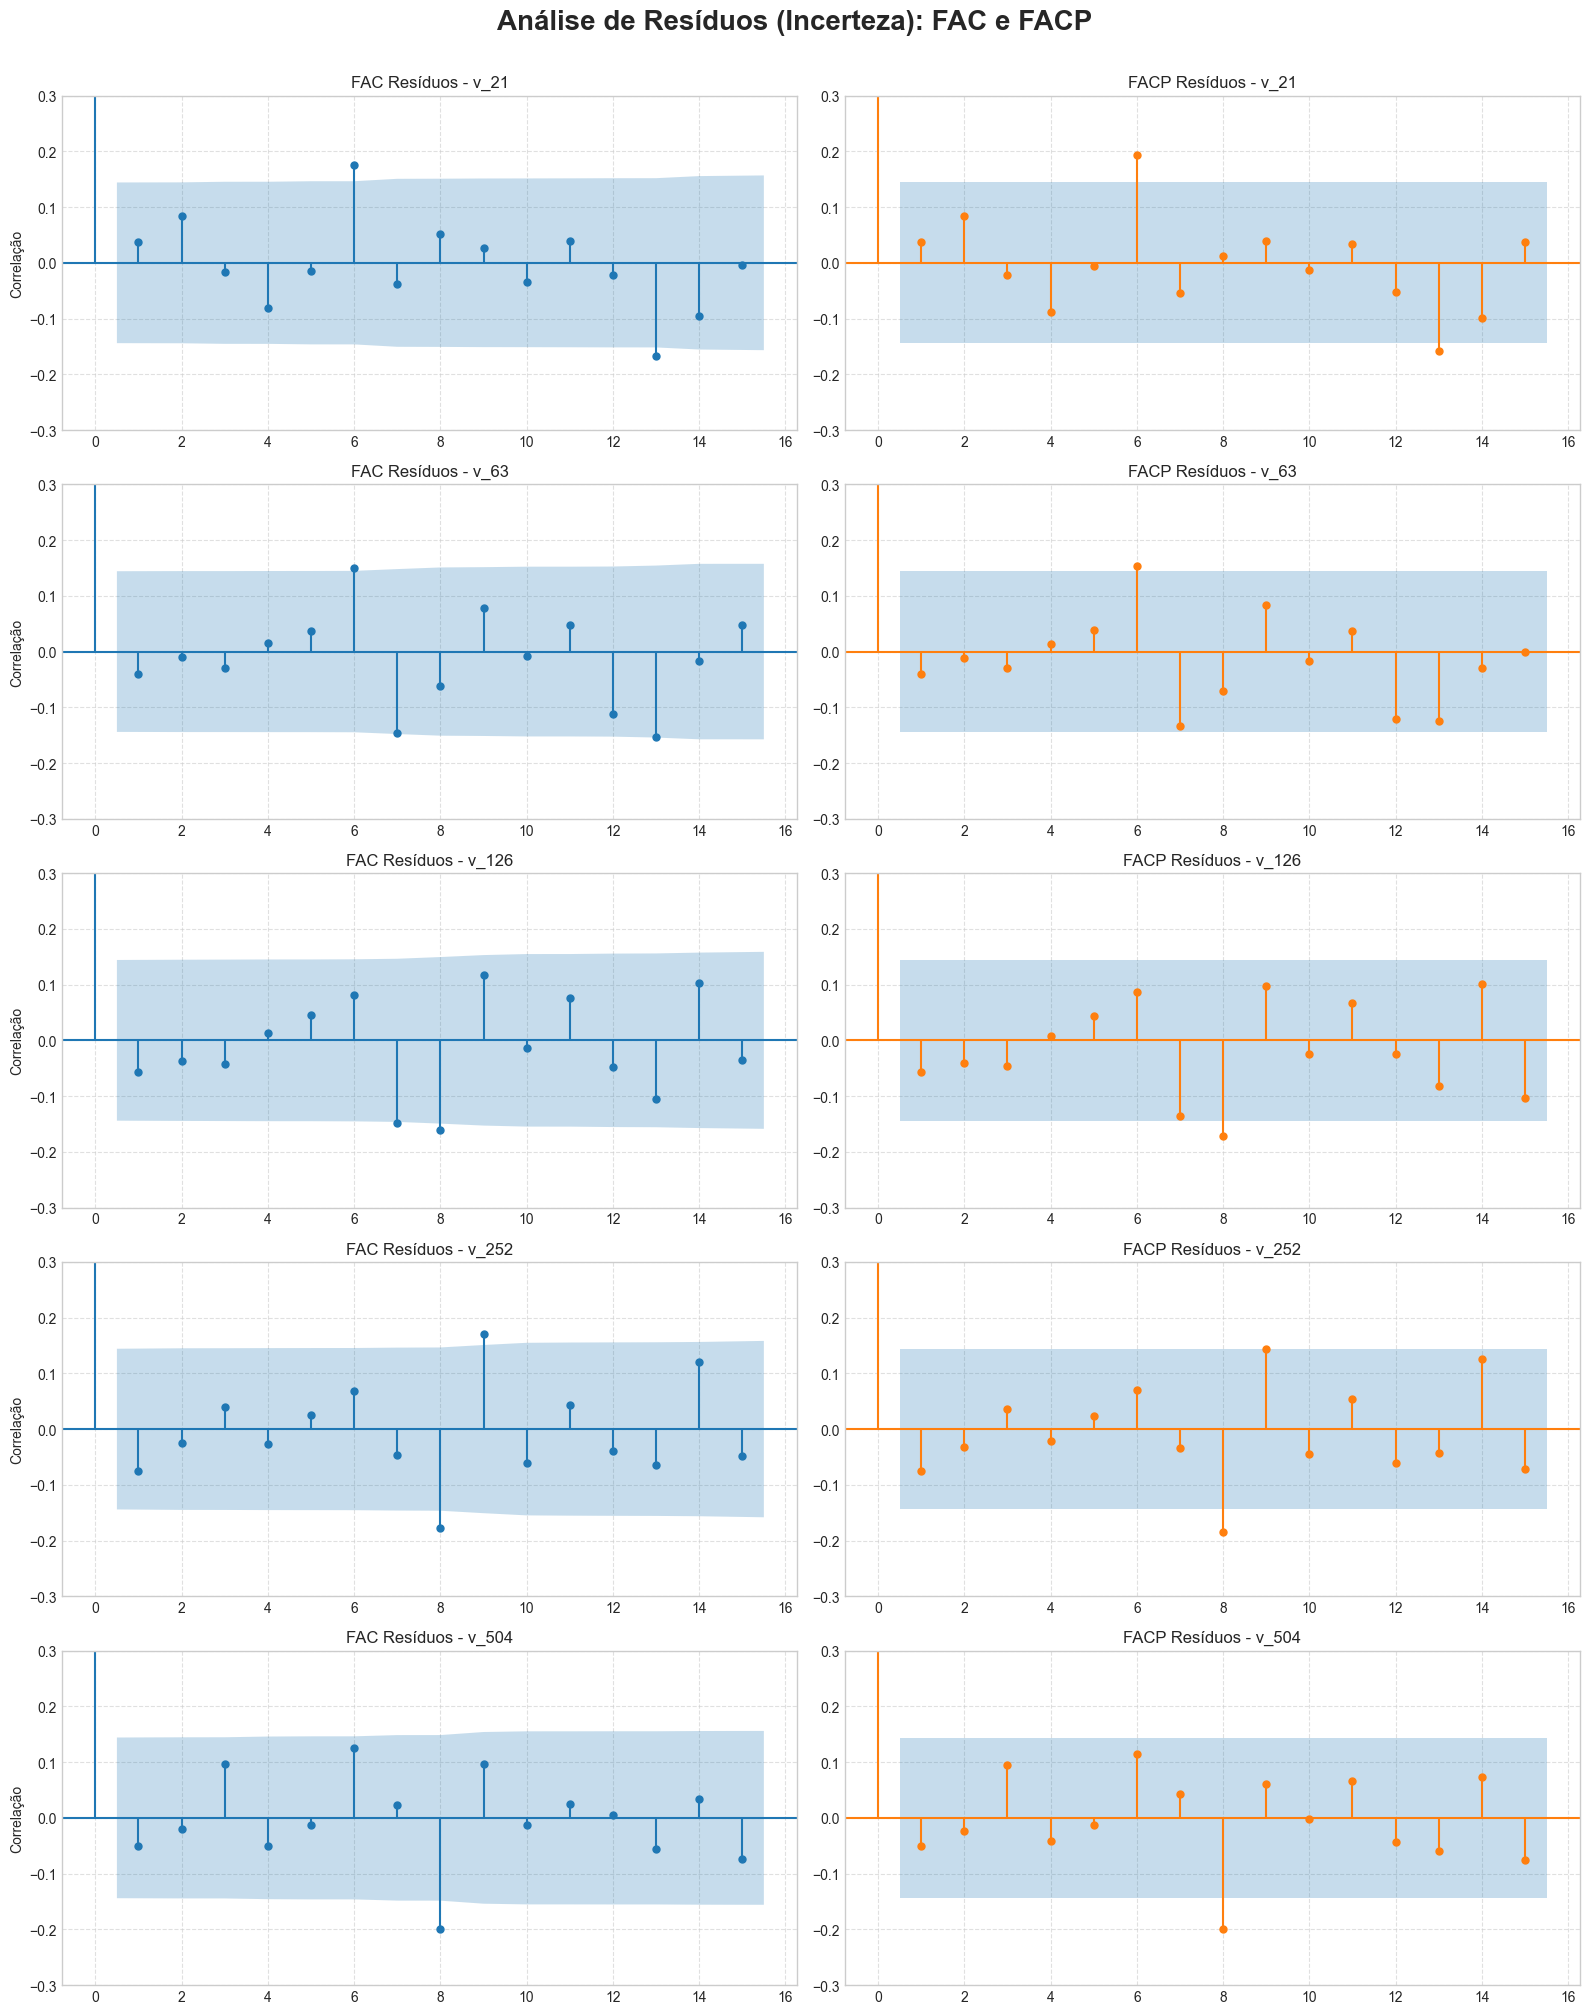

In [ ]:
plt.style.use(seaborn-v0_8-whitegrid") 

results_to_analyze = reg_level_uncertainty  # <--- Aqui mudamos para a lista de incerteza
data_source = regression_data

num_series = len(results_to_analyze)
fig, axes = plt.subplots(nrows=num_series, ncols=2, figsize=(16, 4 * num_series))

fig.suptitle("Análise de Resíduos (Incerteza): FAC e FACP", fontsize=20, weight="bold", y=1.005)

for i, result in enumerate(results_to_analyze):
    vertex = result["Vertix"]
    
    selected_vars = [var for var in result["Coefs_OLS_Final"].index if var != "const"]
    
    Y = data_source[vertex]
    
    if selected_vars:
        X = data_source[selected_vars]
        X = sm.add_constant(X)
    else:
        X = sm.add_constant(pd.DataFrame(index=data_source.index, data=[1]*len(data_source)))

    model_resid = sm.OLS(Y, X).fit()
    residuals = model_resid.resid.dropna()

    # FAC 
    plot_acf(residuals, ax=axes[i, 0], title=f"FAC Resíduos - {vertex}", lags=15, 
             color="tab:blue", vlines_kwargs={"colors": "tab:blue"})
    axes[i, 0].set_ylabel("Correlação")
    axes[i, 0].grid(True, linestyle="--", alpha=0.6)
    axes[i, 0].set_ylim(-0.3, 0.3)

    # FACP
    plot_pacf(residuals, ax=axes[i, 1], title=f"FACP Resíduos - {vertex}", lags=15, 
              color="tab:orange", vlines_kwargs={"colors": "tab:orange"}, method="ywm")
    axes[i, 1].grid(True, linestyle="--", alpha=0.6)
    axes[i, 1].set_ylim(-0.3, 0.3)

plt.tight_layout()
plt.show()